# Link Prediction

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import from_networkx 
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv, to_hetero_with_bases
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn import VGAE
from sklearn.metrics import accuracy_score
from torch import Tensor

/home/ades/miniconda3/envs/pytorchgeo/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. data analysis

In [3]:
g = nx.read_graphml("airportsAndCoordAndPop.graphml")

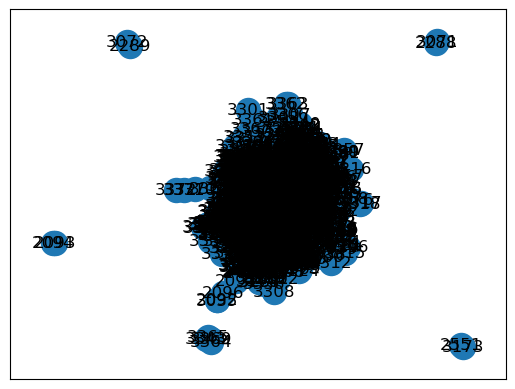

In [3]:
nx.draw_networkx(g)

In [3]:
print(len(g.nodes))
print(len(g.edges))

3363
13547


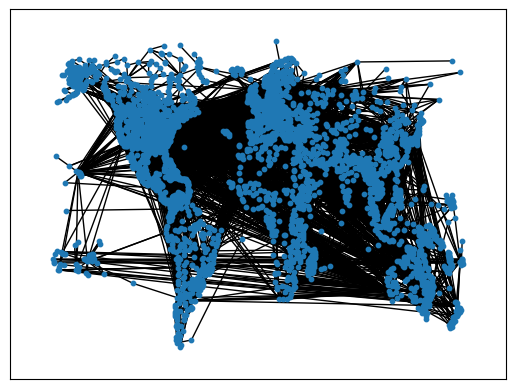

In [4]:
pos = {node: (float(g.nodes[node]['lon']), float(g.nodes[node]['lat'])) for node in g.nodes}
nx.draw_networkx(g, pos=pos, node_size=10, with_labels=False)

With Gephi we have optain this graph:
![](./gephi_analyse/airports_coord_pop_graph.svg)

In [5]:
g.nodes(data=True)

NodeDataView({'0': {'lon': -145.50972222222222, 'lat': -17.35388888888889, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Anaa'}, '1': {'lon': -140.95, 'lat': -18.066666666666666, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Hao Island'}, '2': {'lon': -149.6, 'lat': -17.55, 'population': 26357, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Papeete'}, '3': {'lon': -135.0, 'lat': -23.033333333333335, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Gambier Island'}, '4': {'lon': -143.65725, 'lat': -16.584888888888887, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Makemo'}, '5': {'lon': 174.79166666666666, 'lat': -37.00805555555556, 'population': 417910, 'country': 'NEW_ZEALAND', 'city_name': 'Auckland'}, '6': {'lon': -139.03333333333333, 'lat': -9.8, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Atuona'}, '7': {'lon': -151.75, 'lat': -16.45, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 

In [4]:
g.graph = {}
data = from_networkx(g, group_node_attrs=["lon", "lat"])

data = train_test_split_edges(data, 0.2, 0.8)


/home/ades/miniconda3/envs/pytorchgeo/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


après une  première analyse on se rend compte que grouper avec l'attribut population nous donne des "mauvais" résultat (auc: 0.5, accuracy: 0.5) ces valeurs

In [17]:
print(data)

Data(population=[3363], country=[3363], city_name=[3363], x=[3363, 2], val_pos_edge_index=[2, 2709], test_pos_edge_index=[2, 10837], train_pos_edge_index=[2, 2], train_neg_adj_mask=[3363, 3363], val_neg_edge_index=[2, 2709], test_neg_edge_index=[2, 10837])


## 2. First Model

In [5]:
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2*out_channels)
        self.conv_mu = GCNConv(2*out_channels, out_channels)
        self.conv_logstd = GCNConv(2*out_channels, out_channels)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [6]:
model = Encoder(data.num_features, 16)
model = VGAE(model)

In [7]:
def train(eta: float, train_data):
    model.train()
    optim = torch.optim.Adam(model.parameters(), lr=eta)
    optim.zero_grad()
    z = model.encode(train_data.x, train_data.train_pos_edge_index)
    loss = model.recon_loss(z, train_data.train_pos_edge_index) + (1 / train_data.x.size(0)) * model.kl_loss()
    loss.backward()
    optim.step()
    return float(loss)

In [8]:
def calc_accu_val(model, data):
    model.eval()

    z = model.encode(data.x, data.train_pos_edge_index)

    pos_pred = model.decode(z, data.val_pos_edge_index)
    neg_pred = model.decode(z, data.val_neg_edge_index)
    
    preds = torch.cat([pos_pred, neg_pred], dim=0)
    labels = torch.cat([torch.ones(pos_pred.size(0)), torch.zeros(neg_pred.size(0))], dim=0)

    pred_binary = (preds > 0.5).float()

    accuracy = accuracy_score(labels.cpu(), pred_binary.cpu())

    return accuracy

def calc_accu_test(model, data):
    model.eval()
    
    z = model.encode(data.x, data.train_pos_edge_index)
    
    pos_score = model.decode(z, data.test_pos_edge_index)
    neg_score = model.decode(z, data.test_neg_edge_index)
    
    y_true = torch.cat([torch.ones(data.test_pos_edge_index.size(1)), 
                         torch.zeros(data.test_neg_edge_index.size(1))])
    
    scores = torch.cat([pos_score, neg_score])
    
    y_pred = (scores > 0.5).float()

    accuracy = accuracy_score(y_true.cpu(), y_pred.cpu())
    
    return accuracy

In [9]:
num_epochs = 1000
min_loss = float("+inf")
bepoch = 0
blr = 0
bout = 0
for lr in [0.001, 0.01, 0.1]:
    for epoch in range(1, num_epochs):
        for output in range(32):
            model = Encoder(data.num_features, output)
            model = VGAE(model)
            loss = train(lr, data) 
            if (loss < min_loss):
                min_loss = loss
                bepoch = epoch
                blr = lr
                bout = output

print(f'Epoch {bepoch}, LR: {blr}, NB output: {bout}, Loss: {min_loss:.4f}')

Epoch 592, LR: 0.001, NB output: 1, Loss: 0.0222


In [13]:
model = Encoder(data.num_features, 1)
model = VGAE(model)
for epoch in range(1, 600):
    train(0.001, data)

In [14]:
calc_accu_val(model, data)

0.6842008121077888

In [15]:
calc_accu_test(model, data)

0.6810464150595184

In [117]:
model.eval()
z = model.encode(data.x, data.train_pos_edge_index)
model.test(z, data.test_pos_edge_index, data.test_neg_edge_index)

(0.7010388973847701, 0.6547860184471889)

## 3. Second Model GNN

In [198]:
class GNN(nn.Module):
    def __init__(self, input_num: int, hidden_num: int, output_num: int):
        super(GNN, self).__init__()
        self.hidelayer1 = nn.Linear(input_num, hidden_num)
        self.output = nn.Linear(hidden_num, output_num)

    def forward(self, x: Tensor) -> Tensor:
        x = self.hidelayer1(x)
        x = nn.F.relu(x)
        x = self.output(x)
        return x

In [197]:
model = GNN(data.num_features, 64, 16)

In [203]:
import torch.optim as optim

def train(model, data, lr=0.01, epochs=200):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    model.train()
    
    for epoch in range(epochs):
        optimizer.zero_grad() 
        out = model(data.x, data.edge_index)  
        loss = nn.F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        if epoch % 20 == 0:
            print(f'Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}')

In [204]:
train(model, data)

TypeError: GNN.forward() takes 2 positional arguments but 3 were given